In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

#read in who_life_exp.csv
df = pd.read_csv('who_life_exp.csv')
df.head()

C:\Users\Spencer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Spencer\AppData\Local\Temp\ipykernel_25852\3980266710.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


,country,country_code,region,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,...,che_gdp,une_pop,une_infant,une_life,une_hiv,une_gni,une_poverty,une_edu_spend,une_literacy,une_school
0,Angola,AGO,Africa,2000,47.33730,14.73400,383.5583,0.137985,0.025695,1.47439,...,1.90860,16395.473,122.2,46.522,1.0,2530.0,32.3,2.60753,NaN,NaN
1,Angola,AGO,Africa,2001,48.19789,14.95963,372.3876,0.133675,0.024500,1.94025,...,4.48352,16945.753,118.9,47.059,1.1,2630.0,NaN,NaN,67.40542,NaN
2,Angola,AGO,Africa,2002,49.42569,15.20010,354.5147,0.128320,0.023260,2.07512,...,3.32946,17519.417,115.1,47.702,1.2,3180.0,NaN,NaN,NaN,NaN
3,Angola,AGO,Africa,2003,50.50266,15.39144,343.2169,0.122040,0.021925,2.20275,...,3.54797,18121.479,110.8,48.440,1.3,3260.0,NaN,NaN,NaN,NaN
4,Angola,AGO,Africa,2004,51.52863,15.56860,333.8711,0.115700,0.020545,2.41274,...,3.96720,18758.145,106.2,49.263,1.3,3560.0,NaN,NaN,NaN,NaN


In [2]:
#Create profile for EDA, optional
profile = ProfileReport(df, title='Pandas Profiling Report', minimal=True, correlations={"pearson": {"calculate": True}})
profile.to_file("life_exp_eda.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 166.53it/s]


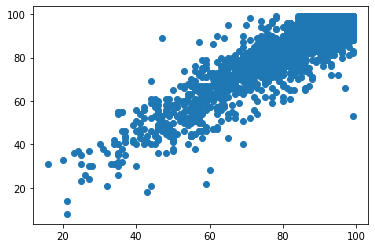

In [3]:
plt.scatter(df['measles'],df['polio'])

### Feature removal and decorrelation

In [4]:
#Based on EDA, the following features are basically the same thing as life expectancy and should be removed
bad_features = ['une_infant', 'une_life', 'country_code']
df = df.drop(columns=bad_features)

#The following features are highly correlated with the target. We may consider trying models with or without these features
highly_correlated_features = ['adult_mortality', 'infant_mort']

#The columns 'diptheria', 'polio', and 'measles' are essentially measuring the same thing and will be averaged under a new column 'diseases'
df['diseases'] = (df['diphtheria'] + df['polio'] + df['measles']) / 3

#The features 'une_gni' and 'gni_capita' are virtually the same feature and the latter will be removed.
df = df.drop(columns=['gni_capita'])

### One-hot-encoding of categorial feature 'region'

In [5]:
df = pd.get_dummies(df, columns=['region'])

In [6]:
df

,country,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,...,une_edu_spend,une_literacy,une_school,diseases,region_Africa,region_Americas,region_Eastern Mediterranean,region_Europe,region_South-East Asia,region_Western Pacific
0,Angola,2000,47.33730,14.73400,383.5583,0.137985,0.025695,1.47439,21.7,11.0,...,2.60753,NaN,NaN,28.000000,1,0,0,0,0,0
1,Angola,2001,48.19789,14.95963,372.3876,0.133675,0.024500,1.94025,21.8,10.9,...,NaN,67.40542,NaN,43.333333,1,0,0,0,0,0
2,Angola,2002,49.42569,15.20010,354.5147,0.128320,0.023260,2.07512,21.9,10.7,...,NaN,NaN,NaN,42.666667,1,0,0,0,0,0
3,Angola,2003,50.50266,15.39144,343.2169,0.122040,0.021925,2.20275,22.0,10.5,...,NaN,NaN,NaN,37.000000,1,0,0,0,0,0
4,Angola,2004,51.52863,15.56860,333.8711,0.115700,0.020545,2.41274,22.2,10.3,...,NaN,NaN,NaN,36.000000,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,Lao People's Democratic Republic,2012,64.49448,16.57977,209.2666,0.055840,0.004845,6.29833,22.4,9.2,...,1.82147,NaN,NaN,76.333333,0,0,0,0,0,1
3107,Lao People's Democratic Republic,2013,64.79716,16.64219,205.1459,0.055350,0.004600,6.42186,22.6,9.1,...,3.23381,NaN,NaN,85.000000,0,0,0,0,0,1
3108,Lao People's Democratic Republic,2014,65.10757,16.70787,200.8204,0.054585,0.004405,6.64447,22.7,9.0,...,2.93781,NaN,NaN,87.666667,0,0,0,0,0,1
3109,Lao People's Democratic Republic,2015,65.45008,16.77074,196.6613,0.053465,0.004160,6.83826,22.8,8.9,...,NaN,84.66104,NaN,81.333333,0,0,0,0,0,1


### Missing value imputation
For the purpose of this analysis we care about modeling a single year for every country. This is because if we include multiple years of the same country as observations, the observations will be highly correlated. So it is better if we simply fit a model to the 200 some-odd points where each country only appears once. Furthermore, it does not really matter that all observations come from the same year, as we only need a "snapshot" of a country at some point in time. Besides, countries are individually on different stages of development so the hypothetical restriction of observations to a single year is completely arbitrary. From a statistical point of view, we only need samples from the joint distribution of covariates, for which any year (independently) will suffice. 

As such, we would like to select, for each country, the year with the fewest number of missing values. We will then impute the remaining missing values based on the last non-null entry for that covariate.

In [7]:
#Find indexes of 'best' rows for each country
best_rows = df.groupby('country').apply(lambda x: x.isna().sum(axis=1).idxmin())

#Fill all of the NaNs using the closest non-NaN entry. Uses alternating forward and backward fill until all NaNs are removed.
country_col = df['country']

for i in range(20):
    if i == 0:
        df_filled = df.groupby('country').fillna(method='ffill', limit=1)
        df_filled['country'] = country_col
        df_filled = df_filled.groupby('country').fillna(method='bfill', limit=1)
        df_filled['country'] = country_col
    else:
        df_filled = df_filled.groupby('country').fillna(method='ffill', limit=1)
        df_filled['country'] = country_col
        df_filled = df_filled.groupby('country').fillna(method='bfill', limit=1)
        df_filled['country'] = country_col

In [8]:
best_observations = df_filled.loc[best_rows]

In [9]:
best_observations

,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,age5-19obesity,...,une_literacy,une_school,diseases,region_Africa,region_Americas,region_Eastern Mediterranean,region_Europe,region_South-East Asia,region_Western Pacific,country
1371,2011,61.72234,16.01989,248.1654,0.067105,0.006270,0.00992,22.8,18.4,2.0,...,31.74112,NaN,66.666667,0,0,1,0,0,0,Afghanistan
1718,2001,73.99104,19.62673,100.4158,0.022340,0.000730,4.50817,25.2,2.2,2.3,...,98.71298,8.74141,96.333333,0,0,0,1,0,0,Albania
603,2008,74.80502,21.01600,108.3998,0.024880,0.001095,0.37239,24.9,6.0,9.0,...,75.13605,7.40254,91.000000,1,0,0,0,0,0,Algeria
14,2014,61.67921,17.21005,243.9467,0.063120,0.008560,7.48675,23.2,8.6,2.0,...,66.03011,3.99596,55.333333,1,0,0,0,0,0,Angola
817,2001,73.02618,19.13280,154.4558,0.011640,0.000445,6.85232,25.2,3.6,5.3,...,98.95000,NaN,97.666667,0,1,0,0,0,0,Antigua and Barbuda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,2001,72.13280,20.29395,174.5862,0.017980,0.000795,8.15050,26.3,1.8,10.1,...,92.97983,7.60344,85.000000,0,1,0,0,0,0,Venezuela (Bolivarian Republic of)
2865,2009,75.28961,22.02871,133.1758,0.018500,0.001205,1.96956,20.9,15.0,0.9,...,93.52045,7.60819,96.666667,0,0,0,0,0,1,Viet Nam
1517,2004,62.46558,15.97963,247.6339,0.059785,0.005360,0.06000,22.7,13.9,2.9,...,54.10000,NaN,72.666667,0,0,1,0,0,0,Yemen
163,2010,57.54378,16.74589,363.5941,0.057145,0.007990,3.58587,22.2,6.7,1.8,...,83.00767,NaN,86.333333,1,0,0,0,0,0,Zambia


### EDA of imputed data

In [10]:
profile = ProfileReport(best_observations, title='Pandas Profiling Report', minimal=True, correlations={"pearson": {"calculate": True}})
profile.to_file("life_expect_best_rows.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 166.51it/s]


### Further NaN handling
There are still missing values. Based on the above EDA, the features with missing values can be split cleanly into two categories: features where only a small (<2%) of countries have missing data, and features where many (>20%) have missing data. It is easy to simply drop the former since it will not significantly impact the number of observations and this takes care of most of the missing values. Then, we can 

* Try regressions on this set of data with reduced number of features (only the ones without missing values). This gives a larger number of observations with fewer features
* Try regressions on only the observations without missing values (but all observations). This gives a larger number of features with fewer observations

In [11]:
few_missing_value_feats = ['alcohol', 'bmi', 'age5-19thinness', 'age5-19obesity', 'hepatitis', 'doctors', 'gghe-d', 'che_gdp', 'une_gni']
many_missing_value_feats = ['hospitals', 'une_hiv', 'une_poverty', 'une_edu_spend', 'une_literacy', 'une_school']

In [12]:
# The first approach, this gives 165 observations, with 26 potential features
obs_full = best_observations.dropna(subset=few_missing_value_feats)
obs_full_obs = obs_full.drop(columns=many_missing_value_feats)
obs_full_obs

,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,age5-19obesity,...,une_pop,une_gni,diseases,region_Africa,region_Americas,region_Eastern Mediterranean,region_Europe,region_South-East Asia,region_Western Pacific,country
1371,2011,61.72234,16.01989,248.1654,0.067105,0.006270,0.00992,22.8,18.4,2.0,...,30117.413,1620.0,66.666667,0,0,1,0,0,0,Afghanistan
603,2008,74.80502,21.01600,108.3998,0.024880,0.001095,0.37239,24.9,6.0,9.0,...,34730.608,12120.0,91.000000,1,0,0,0,0,0,Algeria
14,2014,61.67921,17.21005,243.9467,0.063120,0.008560,7.48675,23.2,8.6,2.0,...,26941.779,6760.0,55.333333,1,0,0,0,0,0,Angola
817,2001,73.02618,19.13280,154.4558,0.011640,0.000445,6.85232,25.2,3.6,5.3,...,77.212,15330.0,97.666667,0,1,0,0,0,0,Antigua and Barbuda
812,2013,76.31533,21.44949,116.4624,0.011435,0.000355,8.20306,27.4,0.9,15.7,...,42196.030,19930.0,92.666667,0,1,0,0,0,0,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,2001,72.13280,20.29395,174.5862,0.017980,0.000795,8.15050,26.3,1.8,10.1,...,24646.472,11840.0,85.000000,0,1,0,0,0,0,Venezuela (Bolivarian Republic of)
2865,2009,75.28961,22.02871,133.1758,0.018500,0.001205,1.96956,20.9,15.0,0.9,...,87092.252,3560.0,96.666667,0,0,0,0,0,1,Viet Nam
1517,2004,62.46558,15.97963,247.6339,0.059785,0.005360,0.06000,22.7,13.9,2.9,...,19540.098,3230.0,72.666667,0,0,1,0,0,0,Yemen
163,2010,57.54378,16.74589,363.5941,0.057145,0.007990,3.58587,22.2,6.7,1.8,...,13605.984,3050.0,86.333333,1,0,0,0,0,0,Zambia


In [13]:
# The second approach, this gives 61 observations, with 32 potential features
mask = best_observations.notnull().all(axis=1)
obs_full_features = best_observations.loc[mask]

In [14]:
obs_full_features

,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,age5-19obesity,...,une_literacy,une_school,diseases,region_Africa,region_Americas,region_Eastern Mediterranean,region_Europe,region_South-East Asia,region_Western Pacific,country
1735,2001,72.18071,18.96136,143.15140,0.028865,0.000935,2.86603,25.7,2.1,2.6,...,99.40016,10.45174,94.666667,0,0,0,1,0,0,Armenia
2580,2013,71.37015,19.23323,137.97630,0.034120,0.002065,0.00402,21.4,18.7,2.0,...,61.01554,5.08167,94.333333,0,0,0,0,1,0,Bangladesh
2525,2009,70.17339,17.48758,225.22220,0.004495,0.000350,13.98003,26.3,2.2,5.3,...,99.61706,11.33366,97.666667,0,0,0,1,0,0,Belarus
36,2002,56.10347,16.42120,283.68710,0.091855,0.014550,1.34153,22.3,9.5,1.0,...,34.65785,2.46291,72.333333,1,0,0,0,0,0,Benin
2596,2012,69.20242,20.07917,222.02600,0.031530,0.001815,0.29944,23.5,16.6,2.3,...,57.03360,2.22245,96.333333,0,0,0,0,1,0,Bhutan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2011,58.61579,14.89114,290.52180,0.060545,0.008140,1.13957,23.2,7.3,1.4,...,60.40994,3.65156,80.666667,1,0,0,0,0,0,Togo
1506,2010,74.89726,19.52879,99.42535,0.015465,0.000645,1.25903,25.9,6.3,6.2,...,79.13058,6.70267,97.666667,0,0,1,0,0,0,Tunisia
131,2012,59.47330,16.94417,335.35090,0.049225,0.006405,8.38765,22.1,5.9,1.2,...,70.19822,5.12872,80.666667,1,0,0,0,0,0,Uganda
1002,2016,77.06158,22.29529,113.93880,0.011750,0.000565,5.52664,27.4,1.5,13.8,...,98.56147,8.71883,95.000000,0,1,0,0,0,0,Uruguay


##### A final approach is to use KNN to impute missing values. This way we can fit to all 182 observations with all 32 potential features.

In [15]:
from sklearn.impute import KNNImputer

df_temp = best_observations.drop(columns=['year','life_expect','country'])
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(df_temp)
obs_imputed = pd.DataFrame(imputed_data, columns=df_temp.columns)

#add back non-numeric columns
for col in ['year','life_expect','country']:
    obs_imputed[col] = list(best_observations[col])

In summary we now have 3 fully non-NaN datasets to use:

* obs_full_obs, a dataset that contains most observations and most features
* obs_full_features, a dataset that contains some observations and all features
* obs_imputed, a dataset that includes all observations and all features but is potentially less accurate as it used KNN on up to 30% of some features.

### Feature tranformations

In [16]:
#Based on EDA, the features to be log-transformed
log_features = ['une_poverty', 'une_gni', 'une_hiv', 'une_pop', 'age1-4mort', 'infant_mort']
log_features_full_obs = ['une_pop', 'age1-4mort', 'infant_mort']

#Transform these features (keeping the old feature) for each of our 3 datasets
for feat in log_features:
    obs_full_features[f'log_{feat}'] = np.log(obs_full_features[feat])
    obs_imputed[f'log_{feat}'] = np.log(obs_imputed[feat])

for feat in log_features_full_obs:
    obs_full_obs[f'log_{feat}'] = np.log(obs_full_obs[feat])

C:\Users\Spencer\AppData\Local\Temp\ipykernel_25852\1738252845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_full_features[f'log_{feat}'] = np.log(obs_full_features[feat])
C:\Users\Spencer\AppData\Local\Temp\ipykernel_25852\1738252845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_full_features[f'log_{feat}'] = np.log(obs_full_features[feat])
C:\Users\Spencer\AppData\Local\Temp\ipykernel_25852\1738252845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

### DONE WITH PREPARING DATA WOOOOOOOOO

# Modeling

In [17]:
import statsmodels.api as sm

def fit_ols(data, predictors = None, drops = None):
    data = data.drop(columns = ['year','country'])

    y = data['life_expect']
    if predictors is not None:
        X = data[predictors]
    elif drops is not None:
        X = data.drop(columns=drops)
        X = X.drop(columns= ['life_expect'])
    else:
        X = data.drop(columns = ['life_expect'])

    X = sm.add_constant(X)
    X = np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))

    model = sm.OLS(y, X).fit()

    return model

In [18]:
model1 = fit_ols(obs_full_obs, drops = highly_correlated_features)
model2 = fit_ols(obs_full_features, drops = highly_correlated_features)
model3 = fit_ols(obs_imputed, drops = highly_correlated_features)

### Try forward and backward selection with AIC as the criterion

In [19]:
# define function for calculating AIC
def get_aic(model):
    return model.aic

# define function for backward feature selection with AIC
def backward_selection_aic(X, y):
    selected = set(X.columns)
    current_score, best_new_score = float('inf'), float('inf')
    while X.shape[1] > 0:
        scores_with_candidates = []
        for candidate in X.columns:
            if candidate in selected:
                model = sm.OLS(y, sm.add_constant(X[list(selected-set([candidate]))])).fit()
                aic = get_aic(model)
                scores_with_candidates.append((aic, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if best_new_score < current_score:
            selected.remove(best_candidate)
            current_score = best_new_score
        else:
            break
    model = sm.OLS(y, sm.add_constant(X[list(selected)])).fit()
    return model

In [20]:
# define function for calculating AIC
def get_aic(model):
    return model.aic

# define function for forward feature selection with AIC
def forward_selection_aic(X, y):
    selected = set()
    current_score, best_new_score = float('inf'), float('inf')
    while X.shape[1] > 0:
        scores_with_candidates = []
        for candidate in X.columns:
            if candidate not in selected:
                model = sm.OLS(y, sm.add_constant(X[list(selected)+[candidate]])).fit()
                bic = get_aic(model)
                scores_with_candidates.append((bic, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if best_new_score < current_score:
            selected.add(best_candidate)
            current_score = best_new_score
        else:
            break
    model = sm.OLS(y, sm.add_constant(X[list(selected)])).fit()
    return model

In [211]:
X = obs_imputed.drop(columns = ['year','country'])
y = obs_imputed['life_expect']

#Also drop the closely related features like infant mortality, etc
X = X.drop(columns=highly_correlated_features)
X = X.drop(columns= ['life_expect'])
X = X.drop(columns= ['life_exp60'])
X = X.drop(columns=['une_poverty', 'une_gni', 'une_hiv', 'une_pop', 'age1-4mort'])
X = X.drop(columns=['log_infant_mort','log_age1-4mort'])

In [221]:
mod_aic_backward= backward_selection_aic(X,y)
mod_aic_forward= forward_selection_aic(X,y)

In [23]:
mod_aic_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     84.47
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.04e-69
Time:                        22:06:20   Log-Likelihood:                -455.41
No. Observations:                 183   AIC:                             942.8
Df Residuals:                     167   BIC:                             994.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           44.2470      5.590      7.916      0.000      33.211      55.283
polio                            0.0484      0.071      0.685      0.494      -0.091       0.188
gghe-d                           0.3685      0.163      2.266      0.025       0.047       0.690
region_Europe                    7.4115      1.276      5.810      0.000       4.893       9.930
region_Western Pacific           8.8458      1.070      8.268      0.000       6.734      10.958
log_une_gni                      1.8670      0.389      4.798      0.000       1.099       2.635
region_Africa                    4.9395      1.047      4.716      0.000       2.871       7.008
region_Americas                  8.3503      1.080      7.730      0.000       6.218      10.483
age5-19thinness                 -0.2822      0.099     -2.845      0.005      -0.478      -0.086
region_Eastern Mediterranean     5.7100      1.396      4.089      0.000       2.953       8.467
region_South-East Asia           8.9900      1.357      6.624      0.000       6.311      11.669
age5-19obesity                   0.2990      0.114      2.619      0.010       0.074       0.525
measles                         -0.0586      0.047     -1.237      0.218      -0.152       0.035
diphtheria                       0.0804      0.069      1.160      0.248      -0.056       0.217
bmi                             -0.7126      0.244     -2.923      0.004      -1.194      -0.231
basic_water                      0.1069      0.030      3.608      0.000       0.048       0.165
diseases                         0.0234      0.006      4.009      0.000       0.012       0.035
log_une_hiv                     -1.4014      0.228     -6.141      0.000      -1.852      -0.951
==============================================================================
Omnibus:                        4.499   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.057
Skew:                          -0.329   Prob(JB):                        0.132
Kurtosis:                       3.316   Cond. No.                     2.05e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.72e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
mod_aic_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     127.1
Date:                Sat, 06 May 2023   Prob (F-statistic):           5.69e-74
Time:                        22:06:20   Log-Likelihood:                -457.56
No. Observations:                 183   AIC:                             937.1
Df Residuals:                     172   BIC:                             972.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           55.7245      6.231      8.943      0.000      43.425      68.023
bmi                             -0.8176      0.231     -3.546      0.001      -1.273      -0.363
basic_water                      0.1156      0.029      4.017      0.000       0.059       0.172
region_Eastern Mediterranean    -2.5881      0.920     -2.812      0.005      -4.405      -0.771
age5-19obesity                   0.3815      0.099      3.860      0.000       0.186       0.577
gghe-d                           0.3350      0.155      2.157      0.032       0.029       0.641
log_une_gni                      1.7066      0.374      4.559      0.000       0.968       2.445
region_Africa                   -3.5001      0.831     -4.209      0.000      -5.141      -1.859
log_une_hiv                     -1.3042      0.217     -6.015      0.000      -1.732      -0.876
age5-19thinness                 -0.2336      0.081     -2.868      0.005      -0.394      -0.073
diphtheria                       0.0886      0.020      4.387      0.000       0.049       0.128
==============================================================================
Omnibus:                        3.951   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.579
Skew:                          -0.266   Prob(JB):                        0.167
Kurtosis:                       3.432   Cond. No.                     3.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Now we try LASSO as a feature selection method

In [25]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# fit Lasso model
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X, y)

LassoCV(cv=5)

In [26]:
#Collect resulting coefficients in dataframe
summary_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_cv.coef_})

#Show only nonzero coefficients
summary_df[summary_df['Coefficient'] != 0].reset_index().drop(columns = ['index'])

,Feature,Coefficient
0,bmi,-0.951555
1,age5-19thinness,-0.257362
2,age5-19obesity,0.410026
3,hepatitis,0.005659
4,measles,-0.030502
5,polio,0.033703
6,diphtheria,0.073439
7,basic_water,0.152293
8,doctors,-0.002661
9,hospitals,-0.020912


LASSO selected 16 features. This is only one less than the backward selection.

### Let's also try bootstrapped LASSO to determine which features are significant

In [27]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.utils import resample
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

class BootstrappedLasso:
    def __init__(self, n_bootstrap=100, n_samples=None, n_features=None, alpha_min=0.0001, alpha_max=1.0, n_alpha=20):
        self.n_bootstrap = n_bootstrap
        self.n_samples = n_samples
        self.n_features = n_features
        self.alpha_min = alpha_min
        self.alpha_max = alpha_max
        self.n_alpha = n_alpha
        self.coefs_ = None
        self.alphas_ = None
        self.X = None
    
    def fit(self, X, y):
        self.X = X
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.coefs_ = np.zeros((self.n_bootstrap, self.n_features))
        self.alphas_ = np.zeros(self.n_bootstrap)
        for i in range(self.n_bootstrap):
            X_b, y_b = resample(X, y, n_samples=self.n_samples, replace=True)
            alpha_list = np.logspace(np.log10(self.alpha_min), np.log10(self.alpha_max), self.n_alpha)
            lasso_cv = LassoCV(alphas=alpha_list, cv=5, max_iter=10_000)
            lasso_cv.fit(X_b, y_b)
            self.coefs_[i,:] = lasso_cv.coef_
            self.alphas_[i] = lasso_cv.alpha_
        return self
    
    def summary(self):
        coefs_mean = np.mean(self.coefs_, axis=0)
        coefs_std = np.std(self.coefs_, axis=0)
        coefs_std_out = np.abs(coefs_mean / (coefs_std + 1e-8))
        coefs_significant = coefs_std_out > 2
        summary_df = pd.DataFrame({'Feature': self.X.columns, 
                                   'Coefficient Mean': coefs_mean, 
                                   'Coefficient Std': coefs_std,
                                   'How Many Std Out': coefs_std_out,
                                   'Significant': coefs_significant})
        return summary_df

In [28]:
significant_features = []

# run bootstrapped lasso
bootlass = BootstrappedLasso()
bootlass.fit(X, y)
summary = bootlass.summary()
significant_features += summary[summary['Significant']]['Feature'].to_list()

print(significant_features)
summary.sort_values(by='How Many Std Out',ascending=False)

['bmi', 'age5-19thinness', 'age5-19obesity', 'basic_water', 'log_une_gni', 'log_une_hiv']


,Feature,Coefficient Mean,Coefficient Std,How Many Std Out,Significant
12,che_gdp,0.002478,0.192165,0.012894,False
15,une_school,-0.008452,0.135309,0.062462,False
9,doctors,-0.005330,0.038623,0.138004,False
10,hospitals,-0.021110,0.149335,0.141361,False
20,region_Europe,-0.094298,0.505811,0.186429,False
16,diseases,-0.034229,0.097477,0.351145,False
6,polio,0.042560,0.118832,0.358150,False
21,region_South-East Asia,0.478907,1.185159,0.404087,False
5,measles,-0.024876,0.058063,0.428436,False
4,hepatitis,0.007490,0.012782,0.585993,False


# Fascinating results here. A lot to say.

### So far I like the forward selected model the best. It has one of the best R^2 despite having one of the fewest numbers of features. Let's look into this model with more detail.

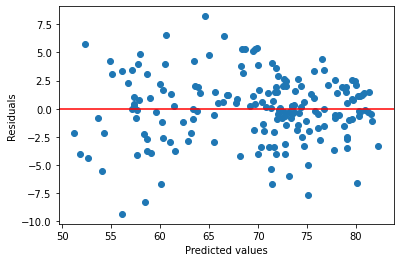

In [31]:
residuals = mod_aic_forward.resid

# Create the residual plot using matplotlib
fig, ax = plt.subplots()
ax.scatter(mod_aic_forward.predict(), residuals)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
plt.show()

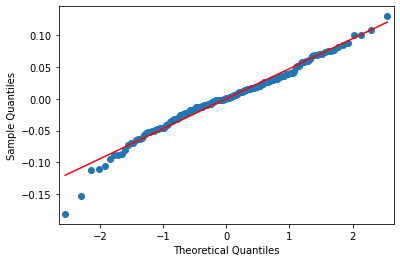

In [40]:
import statsmodels

fig, ax = plt.subplots()
statsmodels.graphics.gofplots.qqplot(residuals, ax=ax, line='r')
plt.show()

According to google this parabolic residual plot can indicate the need for a quadratic term in the model. At least the qq plot is quite good.

In [212]:
fav_model_features = ['bmi', 'basic_water', 'region_Eastern Mediterranean', 'age5-19obesity', 'gghe-d', 'log_une_gni', 'region_Africa', 'log_une_hiv', 'age5-19thinness', 'diphtheria']
fav_model_X = X[fav_model_features]

In [227]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(fav_model_X))

In [228]:
polymod = forward_selection_aic(X_poly,y)

In [229]:
polymod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     104.4
Date:                Sat, 06 May 2023   Prob (F-statistic):           6.07e-80
Time:                        23:10:51   Log-Likelihood:                -421.39
No. Observations:                 183   AIC:                             880.8
Df Residuals:                     164   BIC:                             941.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.2264      5.107     13.360      0.000      58.143      78.310
0             -0.8148      0.244     -3.342      0.001      -1.296      -0.333
2             -9.6991      3.620     -2.679      0.008     -16.848      -2.550
4              0.4960      0.197      2.517      0.013       0.107       0.885
37            -0.0587      0.013     -4.368      0.000      -0.085      -0.032
36             0.0984      0.042      2.346      0.020       0.016       0.181
39             0.0754      0.049      1.526      0.129      -0.022       0.173
42            -0.0717      0.020     -3.525      0.001      -0.112      -0.032
43            -0.0106      0.004     -2.910      0.004      -0.018      -0.003
13             0.0566      0.020      2.818      0.005       0.017       0.096
46             0.9263      0.506      1.831      0.069      -0.073       1.925
47            -0.0376      0.083     -0.452      0.652      -0.202       0.127
54             0.0155      0.003      4.932      0.000       0.009       0.022
22             0.0006      0.005      0.126      0.900      -0.009       0.011
24             0.0081      0.003      2.791      0.006       0.002       0.014
57            -0.5557      0.132     -4.216      0.000      -0.816      -0.295
56            -1.2400      0.496     -2.500      0.013      -2.219      -0.261
59            -0.1973      0.125     -1.575      0.117      -0.445       0.050
60            -0.1192      0.036     -3.347      0.001      -0.190      -0.049
==============================================================================
Omnibus:                        5.654   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                5.989
Skew:                          -0.275   Prob(JB):                       0.0501
Kurtosis:                       3.694   Cond. No.                     3.95e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

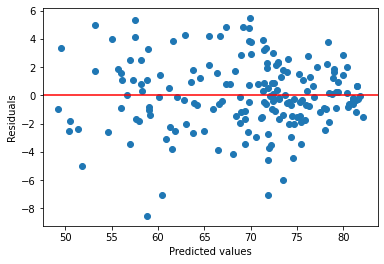

In [230]:
residuals = polymod.resid

# Create the residual plot using matplotlib
fig, ax = plt.subplots()
ax.scatter(polymod.predict(), residuals)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
plt.show()

I've tried a lot of things (not shown). It doesn't seem adding any combination of interaction or squared terms fixes the residuals significantly (at least for any model that is not terribly overfitted).

### Let's try some other diagnostics next

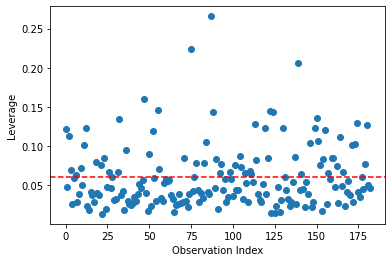

In [232]:
leverage = mod_aic_forward.get_influence().hat_matrix_diag

# Plot the leverage values
plt.plot(np.arange(len(leverage)), leverage, 'o')
plt.axhline(y=np.mean(leverage), color='r', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Leverage')
plt.show()

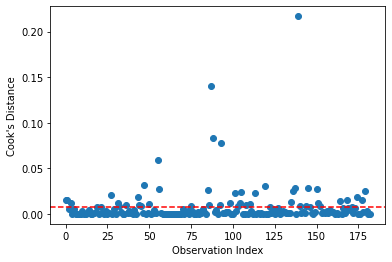

In [234]:
influence = mod_aic_forward.get_influence()
cd, _ = influence.cooks_distance

# Plot the Cook's distance values
plt.plot(np.arange(len(cd)), cd, 'o')
plt.axhline(y=np.mean(cd), color='r', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.show()

In [235]:
np.where(cd > 0.05)

(array([ 55,  87,  88,  93, 139], dtype=int64),)

In [239]:
best_observations.iloc[[55,87,88,93,139]]

,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,age5-19thinness,age5-19obesity,...,une_literacy,une_school,diseases,region_Africa,region_Americas,region_Eastern Mediterranean,region_Europe,region_South-East Asia,region_Western Pacific,country
221,2000,48.63049,15.34542,539.93450,0.082225,0.011565,6.80285,25.5,9.9,1.0,...,81.66070,NaN,87.666667,1,0,0,0,0,0,Eswatini
3073,2013,65.99978,16.78192,202.99580,0.045770,0.003320,0.74510,29.8,0.1,20.4,...,NaN,NaN,92.333333,0,0,0,0,0,1,Kiribati
1655,2006,73.52585,17.21701,87.16492,0.011810,0.000445,0.01498,28.7,3.1,19.9,...,93.28212,6.19119,99.000000,0,0,1,0,0,0,Kuwait
581,2003,46.81549,14.34517,607.87410,0.090445,0.008945,1.97190,24.2,10.6,1.1,...,86.25443,5.82818,88.333333,1,0,0,0,0,0,Lesotho
2898,2008,72.82797,18.46681,139.05050,0.015520,0.000740,3.97080,31.3,0.2,13.9,...,98.97326,11.83690,50.666667,0,0,0,0,0,1,Samoa


In [243]:
fav_model_X_COOKS = fav_model_X.drop([55,87,88,93,139], axis=0)
y_COOKS = y.drop([55,87,88,93,139], axis=0)

In [244]:
cleaned_mod = sm.OLS(y_COOKS, sm.add_constant(fav_model_X_COOKS)).fit()

In [245]:
cleaned_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     143.9
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.22e-76
Time:                        23:32:28   Log-Likelihood:                -428.36
No. Observations:                 178   AIC:                             878.7
Df Residuals:                     167   BIC:                             913.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           50.0564      5.971      8.384      0.000      38.269      61.844
bmi                             -0.6789      0.226     -3.006      0.003      -1.125      -0.233
basic_water                      0.0723      0.028      2.586      0.011       0.017       0.128
region_Eastern Mediterranean    -2.5787      0.853     -3.024      0.003      -4.262      -0.895
age5-19obesity                   0.4205      0.099      4.241      0.000       0.225       0.616
gghe-d                           0.4388      0.149      2.942      0.004       0.144       0.733
log_une_gni                      1.8810      0.357      5.274      0.000       1.177       2.585
region_Africa                   -3.4454      0.766     -4.498      0.000      -4.958      -1.933
log_une_hiv                     -1.2026      0.204     -5.894      0.000      -1.605      -0.800
age5-19thinness                 -0.1471      0.078     -1.890      0.060      -0.301       0.007
diphtheria                       0.1277      0.020      6.424      0.000       0.088       0.167
==============================================================================
Omnibus:                        3.649   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                3.197
Skew:                          -0.280   Prob(JB):                        0.202
Kurtosis:                       3.343   Cond. No.                     3.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

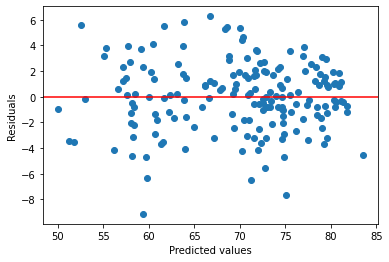

In [246]:
residuals = cleaned_mod.resid

# Create the residual plot using matplotlib
fig, ax = plt.subplots()
ax.scatter(cleaned_mod.predict(), residuals)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
plt.show()

### Residuals looks roughly the same, but the coefficients did change a bit. Perhaps it is more accurate?

# Taking break from this to try the other datasets (Spoiler: it doesnt make much of a difference)

In [194]:
X = obs_full_obs.drop(columns = ['year','country'])
y = obs_full_obs['life_expect']

#Also drop the closely related features like infant mortality, etc
X = X.drop(columns=highly_correlated_features)
X = X.drop(columns= ['life_expect'])
X = X.drop(columns= ['life_exp60'])
X = X.drop(columns=['une_gni', 'une_pop', 'age1-4mort'])
X = X.drop(columns=['log_infant_mort','log_age1-4mort'])

In [195]:
mod_aic_backward= backward_selection_aic(X,y)
mod_aic_forward= forward_selection_aic(X,y)

In [196]:
mod_aic_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     53.55
Date:                Sat, 06 May 2023   Prob (F-statistic):           3.22e-53
Time:                        22:55:57   Log-Likelihood:                -427.13
No. Observations:                 165   AIC:                             888.3
Df Residuals:                     148   BIC:                             941.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           67.1800      5.623     11.948      0.000      56.069      78.291
hepatitis                        0.0204      0.014      1.429      0.155      -0.008       0.049
polio                            0.0587      0.080      0.734      0.464      -0.099       0.217
gghe-d                           0.8739      0.265      3.303      0.001       0.351       1.397
region_Europe                   10.6976      1.462      7.315      0.000       7.808      13.587
region_Western Pacific          12.3321      1.112     11.090      0.000      10.135      14.530
region_Africa                    6.6688      1.056      6.314      0.000       4.582       8.756
region_Americas                 11.7494      1.209      9.716      0.000       9.360      14.139
che_gdp                         -0.3021      0.176     -1.716      0.088      -0.650       0.046
age5-19thinness                 -0.3445      0.124     -2.787      0.006      -0.589      -0.100
region_Eastern Mediterranean    13.0410      1.459      8.939      0.000      10.158      15.924
region_South-East Asia          12.6910      1.629      7.792      0.000       9.472      15.910
age5-19obesity                   0.3852      0.128      3.018      0.003       0.133       0.637
measles                         -0.0373      0.055     -0.681      0.497      -0.145       0.071
diphtheria                       0.0223      0.079      0.283      0.778      -0.134       0.178
bmi                             -1.3098      0.271     -4.840      0.000      -1.844      -0.775
doctors                          0.1158      0.046      2.530      0.012       0.025       0.206
basic_water                      0.1802      0.030      5.952      0.000       0.120       0.240
diseases                         0.0146      0.008      1.865      0.064      -0.001       0.030
==============================================================================
Omnibus:                        2.922   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.232   Jarque-Bera (JB):                2.466
Skew:                          -0.271   Prob(JB):                        0.291
Kurtosis:                       3.254   Cond. No.                     1.88e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.15e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [197]:
mod_aic_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     79.49
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.77e-57
Time:                        22:56:15   Log-Likelihood:                -428.05
No. Observations:                 165   AIC:                             880.1
Df Residuals:                     153   BIC:                             917.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              78.4732      6.239     12.578      0.000      66.148      90.798
hepatitis           0.0220      0.014      1.611      0.109      -0.005       0.049
bmi                -1.2999      0.254     -5.112      0.000      -1.802      -0.798
doctors             0.1105      0.044      2.494      0.014       0.023       0.198
che_gdp            -0.3346      0.164     -2.041      0.043      -0.658      -0.011
age5-19obesity      0.4283      0.119      3.594      0.000       0.193       0.664
polio               0.0630      0.030      2.075      0.040       0.003       0.123
basic_water         0.1764      0.029      6.175      0.000       0.120       0.233
region_Africa      -5.5363      0.869     -6.368      0.000      -7.254      -3.819
age5-19thinness    -0.2775      0.091     -3.033      0.003      -0.458      -0.097
gghe-d              0.9013      0.254      3.550      0.001       0.400       1.403
region_Europe      -1.1433      1.073     -1.066      0.288      -3.263       0.976
==============================================================================
Omnibus:                        3.268   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                2.827
Skew:                          -0.301   Prob(JB):                        0.243
Kurtosis:                       3.220   Cond. No.                     3.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

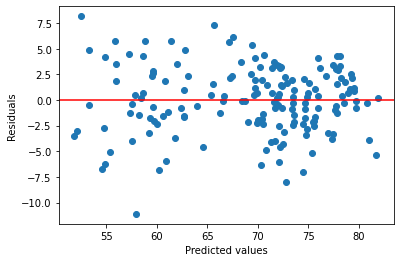

In [198]:
residuals = mod_aic_forward.resid

# Create the residual plot using matplotlib
fig, ax = plt.subplots()
ax.scatter(mod_aic_forward.predict(), residuals)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
plt.show()

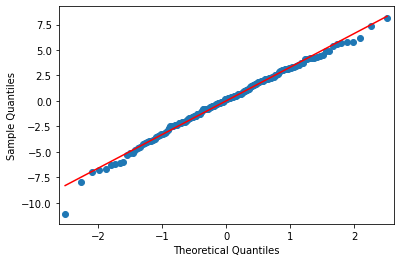

In [199]:
fig, ax = plt.subplots()
statsmodels.graphics.gofplots.qqplot(residuals, ax=ax, line='r')
plt.show()

In [200]:
X = obs_full_features.drop(columns = ['year','country'])
y = obs_full_features['life_expect']

#Also drop the closely related features like infant mortality, etc
X = X.drop(columns=highly_correlated_features)
X = X.drop(columns= ['life_expect'])
X = X.drop(columns= ['life_exp60'])
X = X.drop(columns=['une_poverty', 'une_gni', 'une_hiv', 'une_pop', 'age1-4mort'])
X = X.drop(columns=['log_infant_mort','log_age1-4mort'])

In [201]:
mod_aic_backward= backward_selection_aic(X,y)
mod_aic_forward= forward_selection_aic(X,y)

In [202]:
mod_aic_backward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     51.39
Date:                Sat, 06 May 2023   Prob (F-statistic):           3.35e-23
Time:                        22:59:44   Log-Likelihood:                -132.99
No. Observations:                  61   AIC:                             292.0
Df Residuals:                      48   BIC:                             319.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           77.4277     12.133      6.381      0.000      53.032     101.823
region_Europe                    5.0440      1.483      3.401      0.001       2.062       8.026
log_une_gni                      1.9836      0.755      2.629      0.011       0.466       3.501
region_Americas                  6.3506      1.704      3.726      0.001       2.924       9.777
region_Eastern Mediterranean     3.8561      2.168      1.779      0.082      -0.502       8.215
hospitals                       -0.9192      0.302     -3.048      0.004      -1.526      -0.313
log_une_pop                     -0.7079      0.289     -2.451      0.018      -1.289      -0.127
age5-19obesity                   0.7749      0.226      3.431      0.001       0.321       1.229
une_literacy                     0.0821      0.025      3.265      0.002       0.032       0.133
bmi                             -2.0085      0.476     -4.221      0.000      -2.965      -1.052
basic_water                      0.0625      0.041      1.540      0.130      -0.019       0.144
diseases                         0.1421      0.033      4.325      0.000       0.076       0.208
log_une_hiv                     -1.3586      0.340     -3.997      0.000      -2.042      -0.675
==============================================================================
Omnibus:                        3.153   Durbin-Watson:                   2.498
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.244
Skew:                          -0.375   Prob(JB):                        0.326
Kurtosis:                       3.566   Cond. No.                     5.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [203]:
mod_aic_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            life_expect   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     46.95
Date:                Sat, 06 May 2023   Prob (F-statistic):           1.96e-22
Time:                        23:00:05   Log-Likelihood:                -132.69
No. Observations:                  61   AIC:                             293.4
Df Residuals:                      47   BIC:                             322.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           85.4190     13.012      6.564      0.000      59.241     111.597
region_Western Pacific          -5.6993      1.746     -3.264      0.002      -9.212      -2.186
bmi                             -2.0107      0.521     -3.862      0.000      -3.058      -0.963
une_literacy                     0.0807      0.028      2.913      0.005       0.025       0.137
hospitals                       -0.9433      0.297     -3.176      0.003      -1.541      -0.346
basic_water                      0.0722      0.045      1.617      0.113      -0.018       0.162
region_South-East Asia          -4.9321      1.862     -2.649      0.011      -8.678      -1.186
log_une_pop                     -0.7479      0.291     -2.566      0.014      -1.334      -0.161
age5-19obesity                   0.8798      0.196      4.497      0.000       0.486       1.273
log_une_gni                      1.7760      0.720      2.466      0.017       0.327       3.225
region_Africa                   -5.2134      1.895     -2.751      0.008      -9.026      -1.400
log_une_hiv                     -1.2486      0.423     -2.953      0.005      -2.099      -0.398
measles                          0.1271      0.030      4.305      0.000       0.068       0.187
region_Eastern Mediterranean    -1.8611      1.561     -1.193      0.239      -5.001       1.278
==============================================================================
Omnibus:                        1.752   Durbin-Watson:                   2.549
Prob(Omnibus):                  0.416   Jarque-Bera (JB):                1.075
Skew:                          -0.289   Prob(JB):                        0.584
Kurtosis:                       3.298   Cond. No.                     6.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

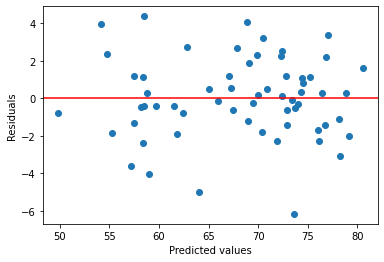

In [204]:
residuals = mod_aic_forward.resid

# Create the residual plot using matplotlib
fig, ax = plt.subplots()
ax.scatter(mod_aic_forward.predict(), residuals)
ax.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
plt.show()

# Turns out the non-imputed dataset performs very similarly.